# Real-world example - Analysis of scDVP liver zonation dataset 

In this example we showcase how spatialdata can be leveraged in the analysis of real-world DVP data. For this purpose we utilize a small subset of the previously published dataset by {cite:p}`Rosenberger2023` [(Rosenberger et al, 2023)](https://doi.org/10.1038/s41592-023-02007-6), specifically the sample `m1a`. This datasets includes 

- IF images (as `.tiff`) of the mouse liver, including the markers Glutamine Synthethase, E-Cadherin, cell membrane marker (WGA), and phalloidin (cytoskeleton)

- Cell segmentation shapes of the profiled cells as LMD-compatible `.xml` file

- Proteomics measurements of 77 single shapes as diann protein groups report (`.tsv`)


We will see how we can use `spatialdata` to jointly store and visualize these different modalities. 

## Packages

To process the different modalities, we import the respective readers from `dvpio` (see the [FAQ](https://dvp-io.readthedocs.io/en/latest/faq.html)) for a full list of available readers). Additionally, we will import some scientific software packages, including spatialdata

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import spatialdata as sd
import spatialdata_plot  # noqa

/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [2]:
from dvpio.read.image import read_custom
from dvpio.read.omics import parse_df
from dvpio.read.shapes import read_lmd

/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get data

In [3]:
image_path = (
    "/Users/lucas-diedrich/Documents/Projects/scverse/spatialdata/spatialdata-io/dvp-io/dvp-io/data/scdvp/images"
)
lmd_path = "/Users/lucas-diedrich/Documents/Projects/scverse/spatialdata/spatialdata-io/dvp-io/dvp-io/data/scdvp/shapes/EXP-220815_m1A_plate-2.pylmd.xml"
protein_group_df_path = "/Users/lucas-diedrich/Documents/Projects/scverse/spatialdata/spatialdata-io/dvp-io/dvp-io/data/scdvp/omics/PXD038699_proteintable.tsv"

## Create spatialdata object

We will successively add attributes to our spatialdata object. Let's initialize an empty object:

In [4]:
sdata = sd.SpatialData()

## Load images

First, we will add the tiff images using the respective dvpio function and visualize it

In [5]:
sdata.images["m1a_image"] = read_custom(path=f"{image_path}/S-BIAD596_m1A_*.tif")

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           


INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3178316032295272].


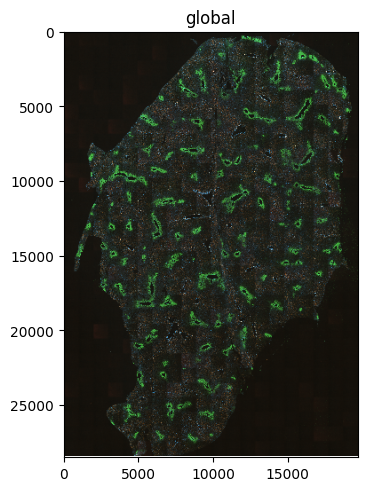

In [6]:
norm = mpl.colors.Normalize(vmin=0, vmax=4000)
sdata.pl.render_images("m1a_image", norm=norm).pl.show()

## Load shapes

Next, we load the shapes. To do this, we will first need to define the calibration points in the image. As the calibration points are not visible in the image, we pass the values that were used in the original publication [(link)](https://github.com/MannLabs/single-cell-DVP/blob/cf9d588849f84409c2e0ce6e3703cc69a1823503/data/meta/coordinates_meta.txt). Alternatively, you can also interactively select the points with `napari_spatildata`, see [Tutorial 2](https://dvp-io.readthedocs.io/en/latest/tutorials/002_read-dvpio.html)

In [7]:
calibration_points = np.array(
    [[1829.65176551, 9110.35230304], [18285.14738192, 3178.46898138], [7115.15875704, 25614.65577448]]
)

sdata.points["calibration_points_image"] = sd.models.PointsModel.parse(calibration_points)

Having defined the calibration points, we can now read the actual shapes from the LMD-compatible `.xml` file and add them to spatialdata.

In [8]:
sdata.shapes["cell_segmentation"] = (
    read_lmd(lmd_path, calibration_points_image=sdata.points["calibration_points_image"])
    .set_index("name", drop=False)
    .rename_axis(None, axis=0)
)

**You should always check/validate whether cell segmentation and image are correctly overlaid.** To do so, we select a small subset of the image and take a look at both cell membrane staining (channel 1) and cell segmentation

/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.11/functools.py:909: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)


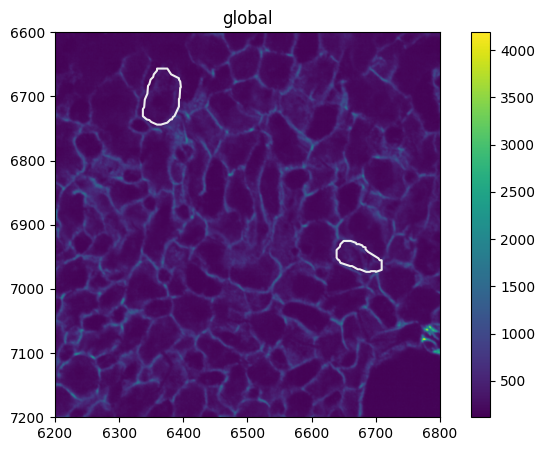

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

min_coordinate = np.array([6200, 6600])
size = 600
(
    sdata.query.bounding_box(
        axes=("x", "y"),
        min_coordinate=min_coordinate,
        max_coordinate=min_coordinate + size,
        target_coordinate_system="global",
    )
    .pl.render_images("m1a_image", channel=1)
    .pl.render_shapes(fill_alpha=0.0, outline_alpha=1, outline_color="#efefef")
    .pl.show(coordinate_systems="global", ax=ax)
)

The overlay between shapes and cell membrane stain looks reasonable. 

## Omics data

Finally, we add the omics data. In this case, we start from the protein.group dataframe as reported by DIANN [(source)]() and use the :func:`dvpio.read.omics.parse_df` function to parse the data into a spatialdata-compatible `anndata.AnnData` container. 

> Note, that the function expects a processed version of the dataframe: Cell-level metadata must be stored in the dataframe row index and will be stored in the `anndata.AnnData.obs` attribute. Gene-level metadata must be stored in the dataframe columns index and will be stored in the `anndata.AnnData.var` attribute. All values of the dataframe will be stored in `anndata.AnnData.X`.

In [10]:
# Read DIANN Report
df = pd.read_csv(protein_group_df_path, sep="\t", index_col="protein").T.reset_index(names="run")

# Parse metadata run into individual metadata columns
metadata_columns = [
    "date",
    "ms",
    "A",
    "B",
    "C",
    "method",
    "sample_id",
    "uniprot_ref",
    "aid",
    "cell_id",
    "D",
    "E",
    "F",
    "G",
]
df[metadata_columns] = df["run"].str.split("_").tolist()

# Create new metadata column `name` that matches the shape names in in the cell segmentation
df["name"] = df["cell_id"].apply(lambda x: f"Shape_{int(x)}")

# Add metadata column that enables spatialdata to match the measurements
# to the cell segmentation shapes (stored in sdata.shapes["cell_segmentation"]) [expects name of shapes attribute]
df["region_key"] = "cell_segmentation"

# Subset to unique cells
# TODO discuss why there are multiple measurements per cell
df = df.groupby("name").first().reset_index()

# Set all metadata columns, including the newly generated ones to the dataframe index
df = df.set_index(["run", "name", "region_key", *sorted(metadata_columns)])

df

,,,,,,,,,,,,,,,,protein,A0A087WQ94,A0A087WR50,A0A087WSP5,A0A0A6YVS2,A0A0A6YW80,A0A0J9YU79,A0A0J9YUI8,A0A0R4IZY2,A0A0R4J083,A0A0R4J0B4,...,P54726,Q61581,Q3V2R3,Q6S9I0,Q9D0J4,Q99N93,Q8CHY6,P11835,P56183,Q6P8J7
run,name,region_key,A,B,C,D,E,F,G,aid,cell_id,date,method,ms,sample_id,uniprot_ref,,,,,,,,,,,,,,,,,,,,,
20220820_TIMS06_FAS_SA_S720_scDVP_m1A_Ref10_AID8_01_S2-A1_1_4970_target4,Shape_1,cell_segmentation,FAS,SA,S720,S2-A1,1,4970,target4,AID8,01,20220820,scDVP,TIMS06,m1A,Ref10,2546.170495,3112.807142,4247.124853,1906.437899,4825.246524,1589.062179,736.197798,6044.616609,6140.588482,1625.809065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20220820_TIMS06_FAS_SA_S720_scDVP_m1A_Ref10_AID8_10_S2-A10_1_4979_target4,Shape_10,cell_segmentation,FAS,SA,S720,S2-A10,1,4979,target4,AID8,10,20220820,scDVP,TIMS06,m1A,Ref10,8077.136135,3330.472828,2268.027890,1526.827577,6940.136352,3275.123797,2150.213041,10486.206852,6641.898142,12554.911721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20220820_TIMS06_FAS_SA_S720_scDVP_m1A_Ref10_AID8_11_S2-A11_1_4980_target4,Shape_11,cell_segmentation,FAS,SA,S720,S2-A11,1,4980,target4,AID8,11,20220820,scDVP,TIMS06,m1A,Ref10,NaN,4435.863428,5348.012649,1748.762739,10268.052605,1197.900908,2981.050155,12238.028228,8792.139128,1203.145811,...,NaN,NaN,3487.29117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20220820_TIMS06_FAS_SA_S720_scDVP_m1A_Ref10_AID8_12_S2-B1_1_4981_target8,Shape_12,cell_segmentation,FAS,SA,S720,S2-B1,1,4981,target8,AID8,12,20220820,scDVP,TIMS06,m1A,Ref10,1196.769924,3220.892955,5649.794082,5531.072645,11462.061995,1891.362297,3109.722352,8266.772895,4655.184605,3886.250550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20220820_TIMS06_FAS_SA_S720_scDVP_m1A_Ref10_AID8_13_S2-B2_1_4982_target8,Shape_13,cell_segmentation,FAS,SA,S720,S2-B2,1,4982,target8,AID8,13,20220820,scDVP,TIMS06,m1A,Ref10,3896.896268,3892.945494,3787.335743,3654.229206,9770.141567,2570.591653,3336.025993,13528.636038,8340.092785,2791.022612,...,NaN,318.401047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20220820_TIMS06_FAS_SA_S720_scDVP_m3B_Ref10_AID8_75_S2-G9_1_4961_target4,Shape_75,cell_segmentation,FAS,SA,S720,S2-G9,1,4961,target4,AID8,75,20220820,scDVP,TIMS06,m3B,Ref10,1853.740651,3846.307917,2964.671425,3770.539387,6331.494696,4519.779519,2492.729865,15927.070502,11184.127594,232.821475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1078.283601
20220820_TIMS06_FAS_SA_S720_scDVP_m3B_Ref10_AID8_76_S2-G10_1_4962_target4,Shape_76,cell_segmentation,FAS,SA,S720,S2-G10,1,4962,target4,AID8,76,20220820,scDVP,TIMS06,m3B,Ref10,4479.211592,2225.215970,3729.255133,1500.205313,20813.766732,5020.883312,2230.125342,8551.449242,5701.956014,1810.053280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20220820_TIMS06_FAS_SA_S720_scDVP_m3B_Ref10_AID8_77_S5-G11_1_4963_target8,Shape_77,cell_segmentation,FAS,SA,S720,S5-G11,1,4963,target8,AID8,77,20220820,scDVP,TIMS06,m3B,Ref10,3994.153689,2295.307398,2192.080927,15405.786639,1908.038186,3279.212194,2958.605514,7308.751211,4870.938330,1780.867609,...,NaN,NaN,NaN,NaN,488.112002,NaN,NaN,NaN,NaN,NaN


In [11]:
# Parse dataframe
# Set anndata.AnnData.var index to protein uniprot accessors to enable querying by protein names (required for plotting)
sdata.tables["m1a_table"] = parse_df(
    df, var_index="protein", region="cell_segmentation", region_key="region_key", instance_key="name"
)
# Inspect
sdata.tables["m1a_table"]

/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.11/site-packages/spatialdata/models/models.py:1053: UserWarning: Converting `region_key: region_key` to categorical dtype.
  return convert_region_column_to_categorical(adata)


AnnData object with n_obs × n_vars = 77 × 3738
    obs: 'run', 'name', 'region_key', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'aid', 'cell_id', 'date', 'method', 'ms', 'sample_id', 'uniprot_ref'
    uns: 'spatialdata_attrs'

After having added the omics layer to the spatialdata object, **we can overlay the proteomics measurement with the imaging**. In this example, we will focus on E-Cadherin ([P09803](https://www.uniprot.org/uniprotkb/P09803/entry)) for which the original authors also developed an antibody-based staining.

/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.11/functools.py:909: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.11/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `cell_segmentation` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.11/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `m1a_table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/lucas-diedrich/anaconda3/envs/dvpio/lib/python3.11/functools.py:909: UserWarning: The object has `points` element. Depending on the number of points

Text(0.5, 1.0, 'Cell segmentation + $\\alpha$-E-Cadherin')

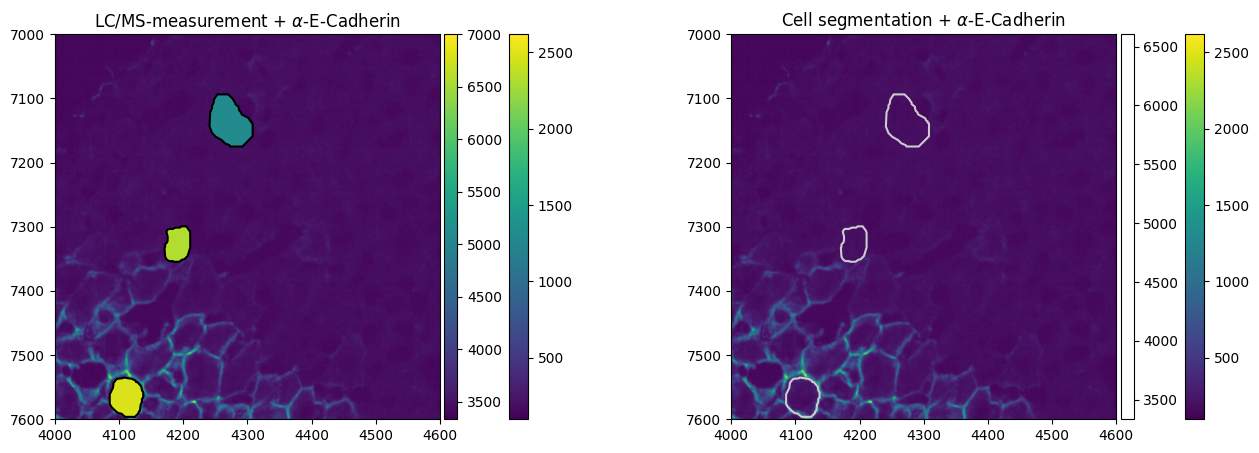

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

min_coordinate = np.array([4000, 7000])
size = 600
(
    sdata
    # Subset to relevant area
    .query.bounding_box(
        axes=("x", "y"),
        min_coordinate=min_coordinate,
        max_coordinate=min_coordinate + size,
        target_coordinate_system="global",
    )
    .pl.render_images("m1a_image", channel=1)
    .pl.render_shapes(
        element="cell_segmentation", color="P09803", norm=mpl.colors.Normalize(0, 7000), outline_alpha=1, fill_alpha=1
    )
    .pl.show(coordinate_systems="global", ax=axs[0])
)

axs[0].set_title("LC/MS-measurement + $\\alpha$-E-Cadherin")

(
    sdata
    # Subset to relevant area
    .query.bounding_box(
        axes=("x", "y"),
        min_coordinate=min_coordinate,
        max_coordinate=min_coordinate + size,
        target_coordinate_system="global",
    )
    .pl.render_images("m1a_image", channel=1)
    .pl.render_shapes(
        element="cell_segmentation", color="P09803", outline_alpha=1, outline_color="#cccccc", fill_alpha=0
    )
    .pl.show(coordinate_systems="global", ax=axs[1])
)

axs[1].set_title("Cell segmentation + $\\alpha$-E-Cadherin")

We note that the staining intensity correlates with the measured abundance of E-Cadherin in the cells. 